# **Problem statement:**

To perform Sentiment Analysis on tweets on any desired topic using scrape.

Now I need textual data which expresses people’s sentiment about **Self driving car**. Few options available are using Reddit API, Facebook API, Twitter API, and scraping data from web pages. I decided to go with twitter API to collect tweets.

The tweets for this project are collected from the Twitter database using Tweepy library in python. 

In [2]:
!pip install tweepy

In [3]:
!pip install nltk

# **Importing the required Library**

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings
# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# To consume Twitter's API
import tweepy
from tweepy import OAuthHandler

import nltk
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# **Collecting Data**

After this, we need to create a new app in their interface and provide its description(as below) which generates API KEY, API SECRET KEY, ACCESS TOKEN, and ACCESS TOKEN SECRET, which we will use to log in through terminal.


In [5]:
# keys and tokens from the Twitter Dev Console
consumer_key = 'Sec3MvclRIx2RVlgu9l0SJX6D'
consumer_secret = 'ayoPNWtBm7fWpMBoK6EwRmegu3SW8Rw9mzJkottkv97quPe941'
access_token = '736550752760406018-so5CPJrEbJKb3c3Pq8va3VFr0yk4S0E'
access_token_secret = 'Cgr8tz0h6FTU7kxAjDzpHnjffNTHxWsBytXnu4Ihd1TFb'

In [6]:
class TwitterClient(object): 
    def __init__(self): 
        #Initialization method. 
        try: 
            # create OAuthHandler object 
            auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            # add hyper parameter 'proxy' if executing from behind proxy "proxy='http://172.22.218.218:8085'"
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Tweeter Authentication Failed - \n{str(e)}")

    def get_tweets(self, query, maxTweets = 1000):
        #Function to fetch tweets. 
        # empty list to store parsed tweets 
        tweets = [] 
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100

        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break

                for tweet in new_tweets:
                    parsed_tweet = {} 
                    parsed_tweet['tweets'] = tweet.text 

                    # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:
                # Just exit if any error
                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)

In [7]:
twitter_client = TwitterClient()

# calling function to get tweets
tweets_df = twitter_client.get_tweets('Self driving cars', maxTweets=1000)
print(f'tweets_df Shape - {tweets_df.shape}')
tweets_df.head(10)

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 700 tweets
Downloaded 800 tweets
Downloaded 900 tweets
Downloaded 1000 tweets
tweets_df Shape - (466, 1)


,tweets
0,RT @akbarth3great: Intel's Mobileye Takes On P...
1,Intel's Mobileye Takes On Parisian Traffic in ...
2,Intel's Mobileye Takes On Parisian Traffic in ...
3,Making self-driving cars safer through keener ...
4,When we’re likely to see self-driving cars rol...
5,RT @ASvanevik: Asking politicians to regulate ...
6,@idrissaberkane Avec sa technologie révolution...
7,If you feel a bit silly and self conscious sho...
8,RT @Marcis06347378: @severesarcasm @SawyerMerr...
9,@tesla @elonmusk # teslaheads try driverless c...


# **Converting useful data to CSV**

In [8]:
tweets_df.to_csv('/content/sample_data/tweets.csv')

In [9]:
df = pd.read_csv('/content/sample_data/tweets.csv')
df.head()

,Unnamed: 0,tweets
0,0,RT @akbarth3great: Intel's Mobileye Takes On P...
1,1,Intel's Mobileye Takes On Parisian Traffic in ...
2,2,Intel's Mobileye Takes On Parisian Traffic in ...
3,3,Making self-driving cars safer through keener ...
4,4,When we’re likely to see self-driving cars rol...


Sentiment analysis is a text analysis method that detects polarity (e.g. a positive or negative opinion) within the text, whether a whole document, paragraph, sentence, or clause.

VADER’s SentimentIntensityAnalyzer() takes in a string and returns a dictionary of scores in each of four categories:

* negative

* neutral

* positive

* compound (computed by normalizing the scores above)

In [10]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
df['scores'] = df['tweets'].apply(lambda Tweets: sid.polarity_scores(Tweets))
df.head()

,Unnamed: 0,tweets,scores
0,0,RT @akbarth3great: Intel's Mobileye Takes On P...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,1,Intel's Mobileye Takes On Parisian Traffic in ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,2,Intel's Mobileye Takes On Parisian Traffic in ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,3,Making self-driving cars safer through keener ...,"{'neg': 0.0, 'neu': 0.677, 'pos': 0.323, 'comp..."
4,4,When we’re likely to see self-driving cars rol...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [12]:
df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment_type']=''
df.loc[df.compound>0,'sentiment_type']='POSITIVE'
df.loc[df.compound==0,'sentiment_type']='NEUTRAL'
df.loc[df.compound<0,'sentiment_type']='NEGATIVE'

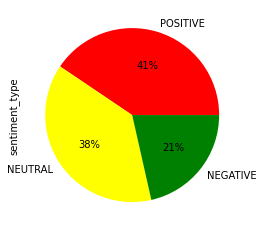

In [13]:
df.sentiment_type.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

In [14]:
df['tweets'][1]

"Intel's Mobileye Takes On Parisian Traffic in Test of Driverless Cars https://t.co/hSRecl3cDu"

# **Cleaning the tweets**

In [15]:
import re
for i in range(len(df)):
    txt = df.loc[i]["tweets"]
    txt=re.sub(r'@[A-Z0-9a-z_:]+','',txt)#replace username-tags
    txt=re.sub(r'^[RT]+','',txt)#replace RT-tags
    txt = re.sub('https?://[A-Za-z0-9./]+','',txt)#replace URLs
    txt=re.sub("[^a-zA-Z]", " ",txt)#replace hashtags
    df.at[i,"tweets"]=txt

In [16]:
df.head(10)

,Unnamed: 0,tweets,scores,compound,sentiment_type
0,0,Intel s Mobileye Takes On Parisian Traffic i...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
1,1,Intel s Mobileye Takes On Parisian Traffic in ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
2,2,Intel s Mobileye Takes On Parisian Traffic in ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
3,3,Making self driving cars safer through keener ...,"{'neg': 0.0, 'neu': 0.677, 'pos': 0.323, 'comp...",0.5106,POSITIVE
4,4,When we re likely to see self driving cars rol...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
5,5,Asking politicians to regulate DeFi is like ...,"{'neg': 0.0, 'neu': 0.857, 'pos': 0.143, 'comp...",0.3612,POSITIVE
6,6,Avec sa technologie r volutionnaire de self d...,"{'neg': 0.081, 'neu': 0.919, 'pos': 0.0, 'comp...",-0.1280,NEGATIVE
7,7,If you feel a bit silly and self conscious sho...,"{'neg': 0.0, 'neu': 0.952, 'pos': 0.048, 'comp...",0.0258,POSITIVE
8,8,Tesla electric cars could have unconventi...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
9,9,teslaheads try driverless cars in parking ...,"{'neg': 0.0, 'neu': 0.872, 'pos': 0.128, 'comp...",0.4215,POSITIVE


# **Word tokenization**

In [17]:
# word tokenization
nltk.download('punkt')
from nltk.tokenize import word_tokenize
token_text = [word_tokenize(text) for text in df['tweets']]
print(token_text)

print('-------------------------------------------')

# sentence tokenization

from nltk.tokenize import sent_tokenize
sent_token = [sent_tokenize(text) for text in df['tweets']]
print(sent_token)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[['Intel', 's', 'Mobileye', 'Takes', 'On', 'Parisian', 'Traffic', 'in', 'Test', 'of', 'Driverless', 'Cars'], ['Intel', 's', 'Mobileye', 'Takes', 'On', 'Parisian', 'Traffic', 'in', 'Test', 'of', 'Driverless', 'Cars'], ['Intel', 's', 'Mobileye', 'Takes', 'On', 'Parisian', 'Traffic', 'in', 'Test', 'of', 'Driverless', 'Cars'], ['Making', 'self', 'driving', 'cars', 'safer', 'through', 'keener', 'robot', 'perception', 'AI', 'ML'], ['When', 'we', 're', 'likely', 'to', 'see', 'self', 'driving', 'cars', 'rolled', 'out', 'in', 'Australia', 'via'], ['Asking', 'politicians', 'to', 'regulate', 'DeFi', 'is', 'like', 'asking', 'taxi', 'drivers', 'to', 'regulate', 'self', 'driving', 'cars'], ['Avec', 'sa', 'technologie', 'r', 'volutionnaire', 'de', 'self', 'driving', 'cars', 'et', 'tout', 'ce', 'que', 'sa', 'apport', 'comme', 'bienfaits'], ['If', 'you', 'feel', 'a', 'bit', 'silly', 'and', 'self', 

# ***Remove punctuation ***

In [18]:
# remove punctuation 

import re

# reg strips URL, punctuations, usernames, 
# and non alphanumeric characters. 
# Also separates words into single space

reg = re.compile('(@[a-z0-9]+)|([^0-9a-z \t])|(\w+:\/\/\S+)')

no_punc = []

for filt in token_text:
    review = []
    for token in filt:
        new_token = reg.sub(u'', token)
        if not new_token == u'':
            review.append(new_token)
    no_punc.append(review)
    
print(no_punc)

[['ntel', 's', 'obileye', 'akes', 'n', 'arisian', 'raffic', 'in', 'est', 'of', 'riverless', 'ars'], ['ntel', 's', 'obileye', 'akes', 'n', 'arisian', 'raffic', 'in', 'est', 'of', 'riverless', 'ars'], ['ntel', 's', 'obileye', 'akes', 'n', 'arisian', 'raffic', 'in', 'est', 'of', 'riverless', 'ars'], ['aking', 'self', 'driving', 'cars', 'safer', 'through', 'keener', 'robot', 'perception'], ['hen', 'we', 're', 'likely', 'to', 'see', 'self', 'driving', 'cars', 'rolled', 'out', 'in', 'ustralia', 'via'], ['sking', 'politicians', 'to', 'regulate', 'ei', 'is', 'like', 'asking', 'taxi', 'drivers', 'to', 'regulate', 'self', 'driving', 'cars'], ['vec', 'sa', 'technologie', 'r', 'volutionnaire', 'de', 'self', 'driving', 'cars', 'et', 'tout', 'ce', 'que', 'sa', 'apport', 'comme', 'bienfaits'], ['f', 'you', 'feel', 'a', 'bit', 'silly', 'and', 'self', 'conscious', 'should', 'you', 'trip', 'up', 'and', 'do', 'that', 'little', 'run', 'to', 'correct', 'yourself', 'whilst', 'car'], ['esla', 'electric', 'ca

# **Removing the stopwords**

Stop words are commonly used words like ‘of’, ’the’, for’ etc., In our context, they don’t add much weight to the sentiment. Also, they increase the dimensionality of data. So we remove the stop words using nltk library(in next part).

In [20]:
# Removing the stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
no_stop = []

for text in no_punc:
    new_term_vector = []
    for word in text:
        if not word in stopwords.words('english'):
            new_term_vector.append(word)
            
    no_stop.append(new_term_vector)
    
print(no_stop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[['ntel', 'obileye', 'akes', 'n', 'arisian', 'raffic', 'est', 'riverless', 'ars'], ['ntel', 'obileye', 'akes', 'n', 'arisian', 'raffic', 'est', 'riverless', 'ars'], ['ntel', 'obileye', 'akes', 'n', 'arisian', 'raffic', 'est', 'riverless', 'ars'], ['aking', 'self', 'driving', 'cars', 'safer', 'keener', 'robot', 'perception'], ['hen', 'likely', 'see', 'self', 'driving', 'cars', 'rolled', 'ustralia', 'via'], ['sking', 'politicians', 'regulate', 'ei', 'like', 'asking', 'taxi', 'drivers', 'regulate', 'self', 'driving', 'cars'], ['vec', 'sa', 'technologie', 'r', 'volutionnaire', 'de', 'self', 'driving', 'cars', 'et', 'tout', 'ce', 'que', 'sa', 'apport', 'comme', 'bienfaits'], ['f', 'feel', 'bit', 'silly', 'self', 'conscious', 'trip', 'little', 'run', 'correct', 'whilst', 'car'], ['esla', 'electric', 'cars', 'could', 'unconventional', 'power', 'source', 'self'], ['teslaheads', 'try',

# **Stemming and Lemmatization**

Stemming reduces the words to their stems. Stemming algorithms are majorly rule-based ones. For instance, they reduce all the above-’distribute’ words to ‘distribut’. A lemmatizer does the same thing as Stemmer but keeping the linguistics of the word in context. For instance, all the above words will be condensed to ‘distribute’.

In [21]:
# Stemming and Lemmatizing
nltk.download('wordnet')
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

pstem = PorterStemmer()
wlem = WordNetLemmatizer()

preproc_text = []

for text in no_stop:
    final_text = []
    for word in text:
        pstem.stem(word)
        final_text.append(wlem.lemmatize(word))
    
    preproc_text.append(final_text)
    
print(preproc_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[['ntel', 'obileye', 'akes', 'n', 'arisian', 'raffic', 'est', 'riverless', 'ar'], ['ntel', 'obileye', 'akes', 'n', 'arisian', 'raffic', 'est', 'riverless', 'ar'], ['ntel', 'obileye', 'akes', 'n', 'arisian', 'raffic', 'est', 'riverless', 'ar'], ['aking', 'self', 'driving', 'car', 'safer', 'keener', 'robot', 'perception'], ['hen', 'likely', 'see', 'self', 'driving', 'car', 'rolled', 'ustralia', 'via'], ['sking', 'politician', 'regulate', 'ei', 'like', 'asking', 'taxi', 'driver', 'regulate', 'self', 'driving', 'car'], ['vec', 'sa', 'technologie', 'r', 'volutionnaire', 'de', 'self', 'driving', 'car', 'et', 'tout', 'ce', 'que', 'sa', 'apport', 'comme', 'bienfaits'], ['f', 'feel', 'bit', 'silly', 'self', 'conscious', 'trip', 'little', 'run', 'correct', 'whilst', 'car'], ['esla', 'electric', 'car', 'could', 'unconventional', 'power', 'source', 'self'], ['teslaheads', 'try', 'driverless',

# Remove web terms like http, html, etc.

In [22]:
# remove web terms like http, html, etc.

reg = re.compile(r'(http)|(^www)|(html$)|(\w*\d{3,}\w*)')

tuned_text = []

for filt in preproc_text:
    review = []
    for token in filt:
        new_token = reg.sub(u'', token)
        if not new_token == u'':
            review.append(new_token)
    tuned_text.append(review)
    
print(tuned_text)

[['ntel', 'obileye', 'akes', 'n', 'arisian', 'raffic', 'est', 'riverless', 'ar'], ['ntel', 'obileye', 'akes', 'n', 'arisian', 'raffic', 'est', 'riverless', 'ar'], ['ntel', 'obileye', 'akes', 'n', 'arisian', 'raffic', 'est', 'riverless', 'ar'], ['aking', 'self', 'driving', 'car', 'safer', 'keener', 'robot', 'perception'], ['hen', 'likely', 'see', 'self', 'driving', 'car', 'rolled', 'ustralia', 'via'], ['sking', 'politician', 'regulate', 'ei', 'like', 'asking', 'taxi', 'driver', 'regulate', 'self', 'driving', 'car'], ['vec', 'sa', 'technologie', 'r', 'volutionnaire', 'de', 'self', 'driving', 'car', 'et', 'tout', 'ce', 'que', 'sa', 'apport', 'comme', 'bienfaits'], ['f', 'feel', 'bit', 'silly', 'self', 'conscious', 'trip', 'little', 'run', 'correct', 'whilst', 'car'], ['esla', 'electric', 'car', 'could', 'unconventional', 'power', 'source', 'self'], ['teslaheads', 'try', 'driverless', 'car', 'parking', 'lot', 'nice', 'experience', 'tried', 'ew'], ['ood', 'ew', 'ongmen', 'rottoes', 'started

In [23]:
cleaned_data = df.copy()

new_col = pd.Series(tuned_text)
cleaned_data['tweets'] = new_col
cleaned_data.head()

,Unnamed: 0,tweets,scores,compound,sentiment_type
0,0,"[ntel, obileye, akes, n, arisian, raffic, est,...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
1,1,"[ntel, obileye, akes, n, arisian, raffic, est,...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
2,2,"[ntel, obileye, akes, n, arisian, raffic, est,...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
3,3,"[aking, self, driving, car, safer, keener, rob...","{'neg': 0.0, 'neu': 0.677, 'pos': 0.323, 'comp...",0.5106,POSITIVE
4,4,"[hen, likely, see, self, driving, car, rolled,...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL


# **Exploratory Data Analysis**

# Term Frequency-Inverse Document Frequency (TF-IDF)

TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. In this case, TF-IDF will allow us to gain insight into how important certain words are in a single tweet but also relative to the rest of the tweets in the dataset.

In [24]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer as tfi
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

tf_idf_vect = tfi(stop_words = 'english', max_features = 20)

x = cleaned_data['tweets']

#data = [tweets.strip() for tweets in cleaned_data['text']]
#texts = [[word.lower() for word in tweet.split()]]
         
tf_idf = tf_idf_vect.fit_transform([' '.join(tweet) for tweet in x])
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

vector = pd.DataFrame(tf_idf_array, columns = tf_idf_vect.get_feature_names())
vector.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ar,ase,autonomous,car,driving,electric,elf,esla,ew,like,make,nd,people,riving,road,self,technology,thing,think,work
0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.555924,0.569137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605831,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.555924,0.569137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605831,0.0,0.0,0.0,0.0


By setting max_features to 20, we can see that the top 20 most frequent words in the tweets of our dataset

# **Modelling-**

To implement K-Means, we need to follow these steps:

* initialize_centroids

* assign_clusters

* update_centroids

* fit_kmeans

* predict

In [25]:
class Kmeans:
    ''' K Means Clustering
    
    Parameters
    -------------------
        k: int, # of clusters
        
        seed: int, will be randomly set if None
        
        max_iter: int, number of iterations to run algorithms, default: 200
        
    Attributes
    ------------------
        centroids: array, k, number_features
        
        cluster_labels: label for each data point
        
    '''
    
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
        
    def intialize_centroids(self,data):
        
        '''Randomly Initialize Centroids
        
        Parameters
        --------------
        data: array or matrix, number_rows, number_features
        
        Returns
        -------------
        centroids: array of k centroids chosen as random data points
        '''
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]
        
        return self.centroids
    
    def assign_clusters(self,data):
        '''Compute distance of data from clusters and assign data point 
        to closest cluster.
        
        Parameters 
        ------------
        data: array or matrix, number_rows, number_features
        
        Returns 
        ------------
        cluster_labels: index which minimizes the distance of data to each cluster
        
        '''
        
        if data.ndim == 1:
            data = data.reshape(-1,1)
            
        dist_to_centroid = pairwise_distances(data,self.centroids, metric = 'euclidean')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        
        return self.cluster_labels
    
    def update_centroids(self,data):
        '''Computes average of all data points in cluster and assigns 
           new centroids as average of data points
           
           Parameters
           -------------
           data: array or matirx, number_rows, number_features
           
           Returns
           -------------
           centroids: array, k, number_features
           '''
        
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
        return self.centroids
    
    def predict(self,data):
        '''Predict which cluster data point belongs to
        
        Parameters
        --------------
        data: array or matirx, number_rows, number_features
        
        Returns
        -------------
        cluster_labels: index which minimizes the distance of data to each
        cluster
        '''
        
        return self.assign_clusters(data)
    
    def fit_kmeans(self, data):
        '''
        This function contains the main loop to fit the algorithm
        Implements initialize centroids and update_centroids according 
        to max_iter
        ---------------------
        
        Returns
        ------------
        instance of kmeans class
        
        '''
        self.centroids = self.intialize_centroids(data)
        
        # Main kmeans loop
        for iter in range(self.max_iter):
            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)
            if iter % 100 == 0:
                print('Running Model Iteration %d ' %iter)
        print('Model finished running')
        return self

Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running


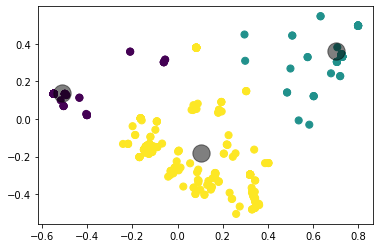

In [28]:
# Own Impementation

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
test_e = Kmeans(3, 1, 600)
fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.5)

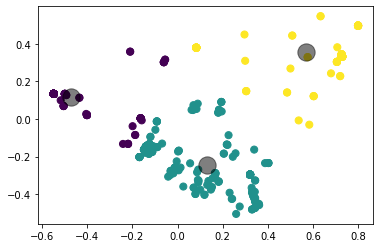

In [29]:
# SKlearn implementation

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto') 
fitted = kmeans.fit(Y_sklearn)
kmeans_prediction = kmeans.predict(Y_sklearn)

skcenters = fitted.cluster_centers_

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=kmeans_prediction, s=50, cmap='viridis')
plt.scatter(skcenters[:, 0], skcenters[:, 1], c='black', s=300, alpha=0.5)

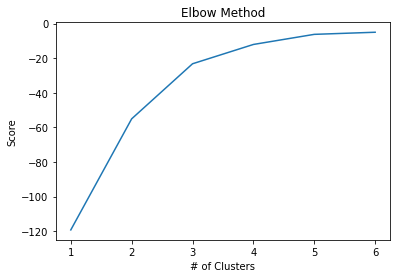

In [30]:
# find out ideal number of clusters using Elbow Method
num_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in num_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(num_clusters, score)
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

### Top Words in Each Cluster: KMeans

Finally, we shall see how KMeans divided our tweets into clusters by using a function that retrieves the features (words) with the highest mean TF_IDF scores in each cluster.

In [32]:
# function that identifies the features with the highest mean tf_idf 
# scores across each cluster
def get_top_feats_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        feats = tf_idf_vect.get_feature_names()
        best_feats = [(feats[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_feats, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

kmeans_dfs = get_top_feats_cluster(tf_idf_array, kmeans_prediction, 15)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


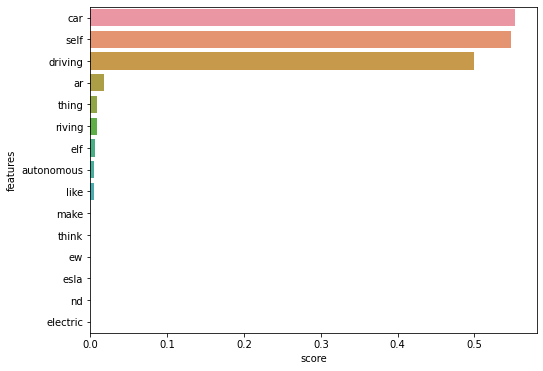

In [33]:
# Cluster 1

plt.figure(figsize=(8,6))
sns.barplot(x='score', y='features',data=kmeans_dfs[0][:15]);

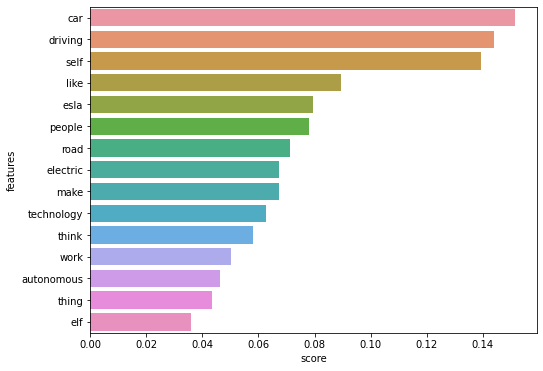

In [34]:
# Cluster 2

plt.figure(figsize=(8,6))
sns.barplot(x='score', y='features',data=kmeans_dfs[1][:15]);

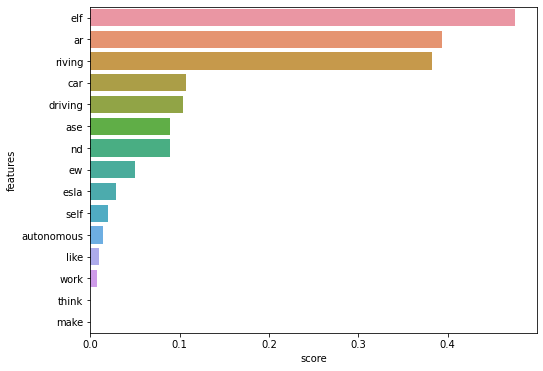

In [36]:
# Cluster 3

plt.figure(figsize=(8,6))
sns.barplot(x='score', y='features',data=kmeans_dfs[2][:15]);

In [42]:
# save clusters to csv
for i, df in enumerate(kmeans_dfs):
    df.to_csv('twitter_kmeans_df' + str(i) + '.csv')